# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
# !pip install networkx==2.3 #uncomment to install networkx 

In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [3]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [4]:
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [5]:
edges = [tuple(x) for x in data.values.tolist()]

In [6]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [7]:
# A = list(nx.connected_component_subgraphs(B))[0]

# connected_component_subgraphs is deprecated in latest version of networkx
# https://networkx.org/documentation/networkx-2.1/reference/algorithms/generated/networkx.algorithms.components.connected_component_subgraphs.html

A = (B.subgraph(c) for c in nx.connected_components(B))
A = list(A)[0]

In [8]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


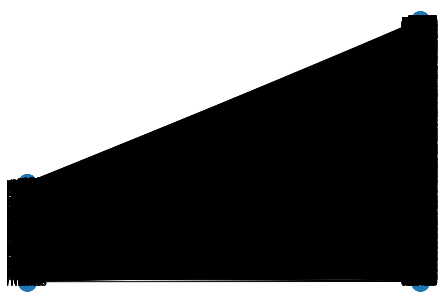

In [9]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [10]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [11]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [12]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [13]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [14]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [15]:
node_ids[0], node_targets[0], node_embeddings[0]

('a973',
 'actor',
 array([ 2.2968585 , -0.481915  , -0.43713924,  1.2701852 , -0.8966316 ,
         1.4080553 , -1.619453  ,  1.1629772 ,  0.994609  , -0.5850619 ,
        -1.2671071 ,  0.23165676,  1.429213  , -2.8537445 ,  0.14174591,
         0.2834468 , -1.2952908 ,  2.482297  , -1.9159162 ,  1.9180504 ,
         0.21335179,  0.5009746 ,  0.07260773, -0.379147  , -0.77380496,
        -0.84458405, -0.9913918 , -0.44498122,  0.67585707,  0.06902331,
         0.31722096,  1.5159738 ,  0.15437867,  0.4415659 , -0.39734492,
        -1.2906413 ,  1.487657  , -0.54228234, -0.14592542, -0.28020644,
         2.5177538 ,  0.11102276, -0.85957307, -0.44956657,  0.38228267,
         0.04148212, -0.24888979, -0.64588577, -1.848014  , -0.28318986,
         0.5169563 ,  0.03273879, -2.0253596 , -0.44164178,  0.03246303,
         2.229213  ,  0.32977495, -1.0699527 ,  0.30627018, -0.99502593,
        -1.8092214 , -1.303003  ,  0.4241739 ,  0.7529667 ,  1.2752202 ,
         0.00554102, -0.5980257 

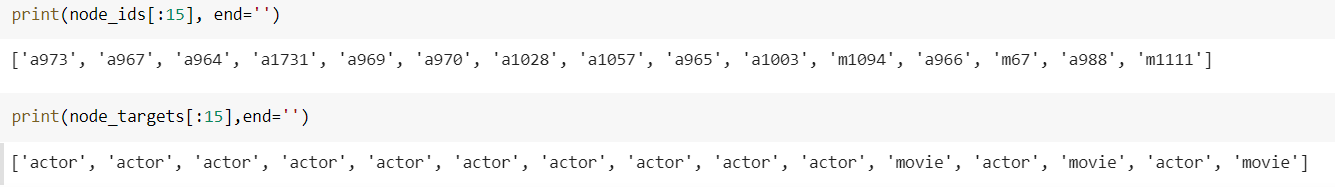

In [201]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    
    for i in range(len(node_ids)):
        if node_targets[i] == 'actor':
            actor_nodes.append(node_ids[i])
            actor_embeddings.append(node_embeddings[i])
        elif node_targets[i] == 'movie':
            movie_nodes.append(node_ids[i])
            movie_embeddings.append(node_embeddings[i])
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


<font color='cyan'>Grader function - 1</font>

In [202]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids, node_targets, node_embeddings)

In [18]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [19]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

1. total no.of nodes in the cluster i
2. largest connected component in the graph with the actor nodes and its movie neighbors in cluster i
    a. find graph with actor nodes

In [20]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost1 = 0# calculate cost1 
    
    # largest connected component **** calculating Numerator
    largest_cc = max(nx.connected_components(graph), key=len)
    
    # total no.of nodes **** calculating denominator
    total_n_nodes = graph.number_of_nodes()
    
    # cost1
    cost1 = (1/number_of_clusters)*(len(largest_cc)/total_n_nodes)
    
    return cost1

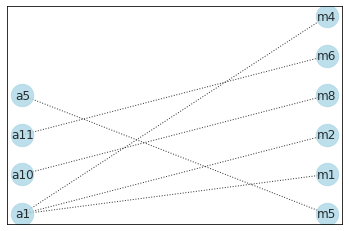

In [21]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [22]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [43]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    cost2= 0 # calculate cost1 
    
    # sum of degree of graph is nothing but no.of edges in the graph.
    numerator_of_cost2 = len(graph.edges())
    
    # calculating denominator for actor nodes
    # no.of unique movie nodes in the graph.
    m_nodes = []
    
    for i in graph.nodes():
        if 'm' in i:
            m_nodes.append(i)
    denominator_of_cost2 = len(m_nodes)
    
    cost2 = (1/number_of_clusters) * (numerator_of_cost2/denominator_of_cost2)
    return cost2

<font color='cyan'>Grader function - 4</font>

In [44]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [149]:
no_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
labels = [] # it stores the labels for each hyper-parameter k
costs = []
for k in tqdm(no_of_clusters):
    # initializing clustering algrithm with no.of clusters k
    algo = KMeans(n_clusters=k)
    
    # fitting the clustering algorithm
    algo.fit(np.array(actor_embeddings))
    
    # getting labels of the cluster
    label=algo.labels_
    labels.append(algo.labels_)
    
    
    ###################################################################################
    # creating graph for every cluster(i.e. if n_clusters=3, create 3 graphs)
    # using ego_graph to create subgraph from the actual graph
    
    clusters = [] # to store k no.of clusters
    subgraphs = [] # store subgraphs for each clusters
    
    
    dictionary_of_actor_nodes = dict(zip(actor_nodes, label))
    # https://www.geeksforgeeks.org/python-grouping-dictionary-keys-by-value/#:~:text=Method%20%3A%20Using%20sorted()%20%2B%20items()%20%2B%20defaultdict()&text=The%20defaultdict()%20is%20used,is%20helped%20by%20sorted().
    res = {} # all node in the forms of cluster stored in the res
    for i, v in dictionary_of_actor_nodes.items():
        res[v] = [i] if v not in res.keys() else res[v]+[i]

    for i in range(k): # for k no.of clusters
        cluster=res[i]
        
        # append the value of cluster
        clusters.append(cluster)
        
        ###############################################################
        # creating subgraph using ego_graph 
        # subgraph = nx.generators.ego_graph(B, cluster)
        
        # create empty subgraph object
        subgraph=nx.Graph()
        for c in cluster: # for each node(actor) in the cluster 
            
            # using ego_graph() function we will create subgraph for node c
            cluster_graph = nx.ego_graph(B, c, radius=3)
            
            # considering neighbors nodes by using nodes() function
            subgraph.add_nodes_from(cluster_graph.nodes())
            # considering edges related to c and neighbor nodes by using edges() function
            subgraph.add_edges_from(cluster_graph.edges())
            
        
        # append the subgraph to list subgraphs
        subgraphs.append(subgraph)
    ###################################################################################
    
    ###################################################################################
    # finding cost
    
    cost = 0
    cost_1 = 0
    cost_2 = 0
    
    for i in range(k):
        cost_1 += cost1(subgraphs[i],k)
        cost_2 += cost2(subgraphs[i],k)
    
    cost = cost_1*cost_2
    
    costs.append(cost)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:27<00:00, 33.42s/it]


In [161]:
losses = dict(zip(no_of_clusters, costs)) # radius is 3 in subgraph
losses

{3: 7.348771042519499,
 5: 7.073581659496938,
 10: 6.311903767847192,
 30: 4.9867566716467975,
 50: 4.247489923611839,
 100: 3.347193333596669,
 200: 2.6472657644254403,
 500: 2.047604271928263}

In [179]:
max_cost = max(losses.values())
best_k = [key for key in losses if losses[key]==max_cost][0]
best_k

3

<font color='blue'>Displaying similar actor clusters</font>

In [180]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [181]:
%%time
algo = KMeans(n_clusters=best_k)
algo.fit(actor_embeddings)
label = algo.labels_

Wall time: 379 ms


In [182]:
# algo.get_params()

In [183]:
len(actor_embeddings) == len(algo.labels_)

True

In [184]:
from sklearn.manifold import TSNE

In [185]:
tsne = TSNE() # initializing TSNE

In [186]:
%%time
actor_embeddings_2d = tsne.fit_transform(actor_embeddings)

Wall time: 44.6 s


In [187]:
np.array(actor_embeddings).shape, algo.labels_.shape

((4703, 128), (4703,))

In [188]:
actor_embeddings = np.array(actor_embeddings)
actor_cluster_labels = np.array(algo.labels_).reshape(-1,1)

In [189]:
actor_embeddings_2d.shape

(4703, 2)

In [190]:
tsne_data = np.hstack((actor_embeddings_2d, actor_cluster_labels))
tsne_data.shape

(4703, 3)

In [191]:
tsne_df = pd.DataFrame(data=tsne_data, columns=["dim_1", "dim_2", "label"])

In [226]:
#plotting the result of TSNE
# import seaborn as sns
# sns.FacetGrid(tsne_df, hue="label", size=7).map(plt.scatter, 'dim_1', 'dim_2')
# plt.legend()

(-99.99903945922851, 76.74806289672851, -80.71826934814453, 72.78759002685547)

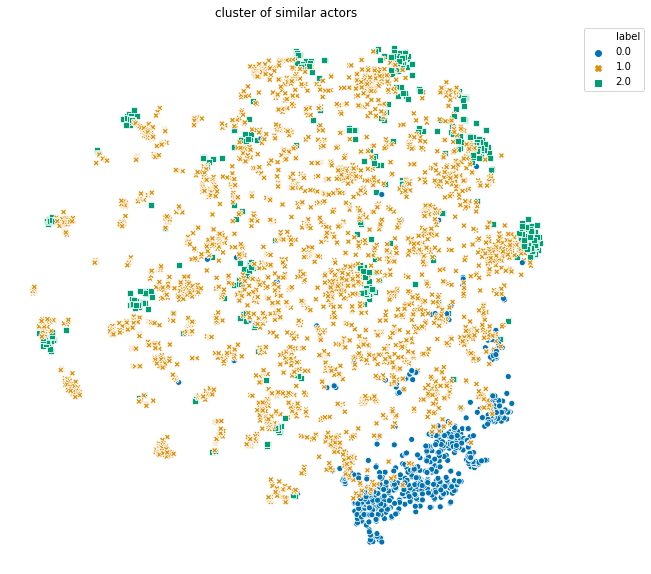

In [253]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=tsne_df, x='dim_1', y='dim_2', hue='label',palette='colorblind', style='label')
plt.title('cluster of similar actors')
plt.legend(bbox_to_anchor=(1.15,1))
plt.axis(False)

<font color='blue'>Grouping similar movies</font>

    we will have to redefine cost2 for task2

In [194]:
def cost2_task2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    cost2= 0 # calculate cost1 
    
    # sum of degree of graph is nothing but no.of edges in the graph.
    numerator_of_cost2 = len(graph.edges())
    
    # calculating denominator for actor nodes
    # no.of unique movie nodes in the graph.
    m_nodes = []
    
    for i in graph.nodes():
        if 'm' in i:
            m_nodes.append(i)
    denominator_of_cost2 = len(m_nodes)
    
    cost2 = (1/number_of_clusters) * (numerator_of_cost2/denominator_of_cost2)
    return cost2

In [204]:
np.array(movie_embeddings).shape

(1292, 128)

In [205]:
no_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
movie_labels = [] # it stores the labels for each hyper-parameter k
movie_costs = []
for k in tqdm(no_of_clusters):
    # initializing clustering algrithm with no.of clusters k
    algo = KMeans(n_clusters=k)
    
    # fitting the clustering algorithm
    algo.fit(np.array(movie_embeddings))
    
    # getting labels of the cluster
    movie_label=algo.labels_
    movie_labels.append(algo.labels_)
    
    
    ###################################################################################
    # creating graph for every cluster(i.e. if n_clusters=3, create 3 graphs)
    # using ego_graph to create subgraph from the actual graph
    
    clusters = [] # to store k no.of clusters
    subgraphs = [] # store subgraphs for each clusters
    
    
    dictionary_of_movie_nodes = dict(zip(movie_nodes, movie_label))
    # https://www.geeksforgeeks.org/python-grouping-dictionary-keys-by-value/#:~:text=Method%20%3A%20Using%20sorted()%20%2B%20items()%20%2B%20defaultdict()&text=The%20defaultdict()%20is%20used,is%20helped%20by%20sorted().
    res = {} # all node in the forms of cluster stored in the res
    for i, v in dictionary_of_movie_nodes.items():
        res[v] = [i] if v not in res.keys() else res[v]+[i]

    for i in range(k): # for k no.of clusters
        cluster=res[i]
        
        # append the value of cluster
        clusters.append(cluster)
        
        ###############################################################
        # creating subgraph using ego_graph 
        # subgraph = nx.generators.ego_graph(B, cluster)
        
        # create empty subgraph object
        subgraph=nx.Graph()
        for c in cluster: # for each node(actor) in the cluster 
            
            # using ego_graph() function we will create subgraph for node c
            cluster_graph = nx.ego_graph(B, c, radius=3)
            
            # considering neighbors nodes by using nodes() function
            subgraph.add_nodes_from(cluster_graph.nodes())
            # considering edges related to c and neighbor nodes by using edges() function
            subgraph.add_edges_from(cluster_graph.edges())
            
        
        # append the subgraph to list subgraphs
        subgraphs.append(subgraph)
    ###################################################################################
    
    ###################################################################################
    # finding cost
    
    cost = 0
    cost_1 = 0
    cost_2 = 0
    
    for i in range(k):
        cost_1 += cost1(subgraphs[i],k)  # cost1 is same for both tasks
        cost_2 += cost2_task2(subgraphs[i],k) # cost2_task2 is for task2
    
    cost = cost_1*cost_2
    
    movie_costs.append(cost)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:05<00:00, 30.65s/it]


In [207]:
movie_losses = dict(zip(no_of_clusters, movie_costs))
movie_losses

{3: 7.8094703366210485,
 5: 8.096429972663195,
 10: 8.792184226293946,
 30: 9.38208562079421,
 50: 9.858718825969907,
 100: 9.767095498512367,
 200: 9.729484165561164,
 500: 9.056170747277505}

In [208]:
max_cost = max(movie_losses.values())
best_k2 = [key for key in movie_losses if movie_losses[key]==max_cost][0]
best_k2

50

<font color='blue'>Displaying similar movie clusters</font>

In [206]:
from sklearn.cluster import KMeans

In [209]:
%%time
movie_algo = KMeans(n_clusters=best_k2)
movie_algo.fit(np.array(movie_embeddings))
label2 = movie_algo.labels_

Wall time: 1.38 s


In [210]:
from sklearn.manifold import TSNE
tsne = TSNE()
movie_embeddings_2d = tsne.fit_transform(np.array(movie_embeddings))

In [211]:
movie_embeddings_2d.shape

(1292, 2)

In [212]:
movie_embeddings = np.array(movie_embeddings)
movie_embeddings.shape

(1292, 128)

In [213]:
movie_cluster_labels = np.array(movie_algo.labels_).reshape(-1,1)

In [214]:
tsne_data2 = np.hstack((movie_embeddings_2d, movie_cluster_labels))
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=["dim_1","dim_2","label"])

In [228]:
# import seaborn as sns
# sns.FacetGrid(tsne_df2, hue='label', size=7).map(plt.scatter, 'dim_1', 'dim_2')
# plt.legend()

(-43.47442779541016, 42.865518188476564, -47.57805061340332, 50.2537784576416)

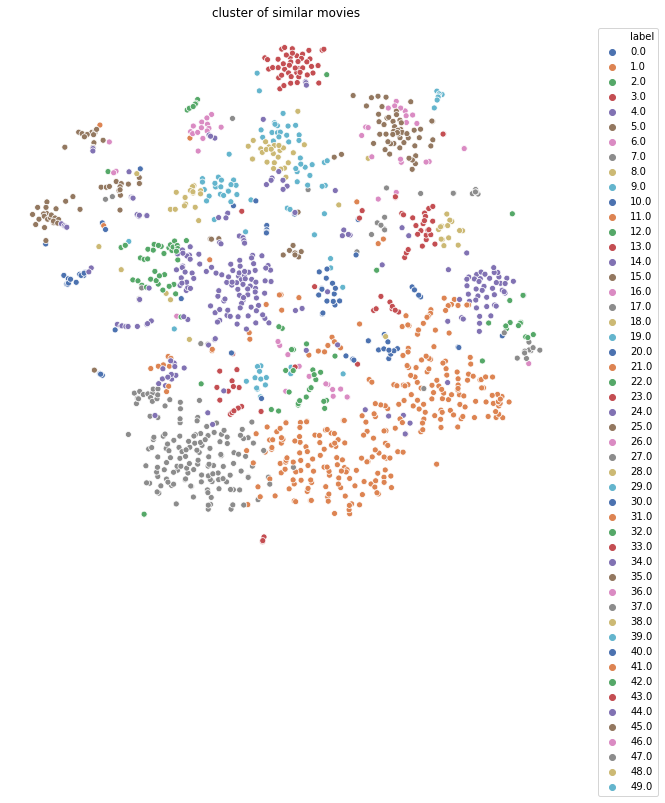

In [254]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=tsne_df2, x='dim_1', y='dim_2', hue='label', palette='deep')
# https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('cluster of similar movies')
plt.axis('off')